# DL - Eyeglasses Segmentation Model

This notebook illustrates working with dataset and building UNet for semantic image segmentation. Used architecture is also a fully convolutional network. The dataset is a collection of images of people with and without eyeglasses. The goal is to segment the eyeglasses in the images.

## Imports

In [1]:
import os
import zipfile
import gdown
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

### Check the GPU availability

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Download the dataset

In [3]:
url = f'https://drive.google.com/uc?id=1TNCPvSqZPg3joEozYYizIZS6u5Ij29kp'

output = 'eyeglasses_dataset.zip'
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1TNCPvSqZPg3joEozYYizIZS6u5Ij29kp
From (redirected): https://drive.google.com/uc?id=1TNCPvSqZPg3joEozYYizIZS6u5Ij29kp&confirm=t&uuid=8af640a4-4073-4e25-98b5-58099c7feb6d
To: /content/eyeglasses_dataset.zip
100%|██████████| 877M/877M [00:14<00:00, 61.5MB/s]


'eyeglasses_dataset.zip'

In [4]:
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('eyeglasses_dataset')

## Prepare the dataset

Initializing the folders (May need to be changed, based on the environment)

In [5]:
train_img = '/content/eyeglasses_dataset/eyeglasses_dataset/train/images'
train_mask = '/content/eyeglasses_dataset/eyeglasses_dataset/train/masks'
val_img = '/content/eyeglasses_dataset/eyeglasses_dataset/val/images'
val_mask = '/content/eyeglasses_dataset/eyeglasses_dataset/val/masks'
test_img = '/content/eyeglasses_dataset/eyeglasses_dataset/test/images'
test_mask = '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks'

### Explore the dataset

Checking the images number and their sizes in the dataset folders.

In [6]:
def calculate_image_statistics(folder_path):
    heights = []
    widths = []
    image_count = 0

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with Image.open(file_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
            image_count += 1

    avg_height = np.mean(heights)
    max_height = np.max(heights)
    min_height = np.min(heights)

    avg_width = np.mean(widths)
    max_width = np.max(widths)
    min_width = np.min(widths)

    return {
        'num_images': image_count,
        'avg_height': avg_height,
        'max_height': max_height,
        'min_height': min_height,
        'avg_width': avg_width,
        'max_width': max_width,
        'min_width': min_width
    }

statistics = calculate_image_statistics(train_img)
print(statistics)


{'num_images': 1992, 'avg_height': 512.0, 'max_height': 512, 'min_height': 512, 'avg_width': 512.0, 'max_width': 512, 'min_width': 512}


### Create the dictionary of the images path and their masks

In [7]:
def create_image_mask_dictionary(image_path, mask_path):
  """
  Creates a dictionary with keys as image-mask pairs based on their file names.

  Args:
    image_path: Path to the directory containing images.
    mask_path: Path to the directory containing masks.

  Returns:
    A dictionary with image path as keys and corresponding mask path as values.
  """
  image_mask_dict = {}
  for filename in os.listdir(image_path):
    if filename.endswith(".png"):
      image_basename = filename[:7]
      for mask_filename in os.listdir(mask_path):
        if mask_filename.endswith(".png"):
          mask_basename = mask_filename[:7]
          if image_basename == mask_basename:
            image_full_path = os.path.join(image_path, filename)
            mask_full_path = os.path.join(mask_path, mask_filename)
            image_mask_dict[image_full_path] = mask_full_path
            break

  return image_mask_dict

In [8]:
train_data = {}
val_data = {}
test_data = {}

train_data = create_image_mask_dictionary(train_img, train_mask)
val_data = create_image_mask_dictionary(val_img, val_mask)
test_data = create_image_mask_dictionary(test_img, test_mask)
print(test_data)

{'/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58223_0_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks/58223_0_mask.png', '/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58277_1_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks/58277_1_mask.png', '/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58162_2_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks/58162_2_mask.png', '/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58196_0_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks/58196_0_mask.png', '/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58208_1_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/test/masks/58208_1_mask.png', '/content/eyeglasses_dataset/eyeglasses_dataset/test/images/58234_0_generated_0_00001_.png': '/content/eyeglasses_dataset/eyeglasses_dataset/tes

### Preparing the train, validation and test sets.

Preprocess the data:

- augmentation by flipping the image
- normalizing the pixel values
- resizing the images
- resizing the masks
- converting the masks to binary

In [9]:
size=256

def random_flip(input_image, input_mask):
  """does a random flip of the image and mask"""
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  """
  Normalizes the input image and input mask pixel values to be in the range [0, 1].
  Converts the pixel values of the input mask to 0 and 1.
  """
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32) / 255.0
  input_mask = tf.where(input_mask > 0.5, 1.0, 0.0)
  return input_image, input_mask


def load_image(path):
    """loads an image from a file path"""
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    return image


def load_mask(path):
    """loads a mask from a file path"""
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)

    return mask

def load_image_train(dictionary, image_size=(size, size)):
    """resizes, normalizes, and flips the training and validation data"""
    for image_key, mask_key in dictionary.items():
        input_image = load_image(image_key)
        input_mask = load_mask(mask_key)
        input_image = tf.image.resize(input_image, image_size, method='nearest')
        input_mask = tf.image.resize(input_mask, image_size, method='nearest')
        input_image, input_mask = random_flip(input_image, input_mask)
        input_image, input_mask = normalize(input_image, input_mask)
        yield input_image, input_mask


def load_image_test(dictionary, image_size=(size, size)):
    """resizes and normalizes the training data"""
    for image_key, mask_key in dictionary.items():
        input_image = load_image(image_key)
        input_mask = load_mask(mask_key)
        input_image = tf.image.resize(input_image, image_size, method='nearest')
        input_mask = tf.image.resize(input_mask, image_size, method='nearest')
        input_image, input_mask = normalize(input_image, input_mask)
        yield input_image, input_mask

### Preprocessing training validation and test sets.

In [10]:
train = tf.data.Dataset.from_generator(
    lambda: load_image_train(train_data),
    output_signature=(
        tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(size, size, 1), dtype=tf.float32),
    )
)

val = tf.data.Dataset.from_generator(
    lambda: load_image_train(val_data),
    output_signature=(
        tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(size, size, 1), dtype=tf.float32),
    )
)

test = tf.data.Dataset.from_generator(
    lambda: load_image_test(test_data),
    output_signature=(
        tf.TensorSpec(shape=(size, size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(size, size, 1), dtype=tf.float32),
    )
)

### Prepare batches for training, validation and testing.

In [11]:
BATCH_SIZE =  24
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# shuffle and group the validation set into batches
val_dataset = val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(10)

### Functions to help visualize the data and metrics.

In [12]:
# class list of the mask pixels
class_names = ['background', 'glasses']


def display_with_metrics(display_list, iou_list, dice_score_list):
  """displays a list of images/masks and overlays a list of IOU and Dice Scores"""

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
  """displays a list of images/masks"""

  plt.figure(figsize=(10, 5))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()

def show_image_from_dataset(dataset):
  """displays the first image and its mask from a dataset"""

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "Mask"])

Display processed images and masks from test and train sets.

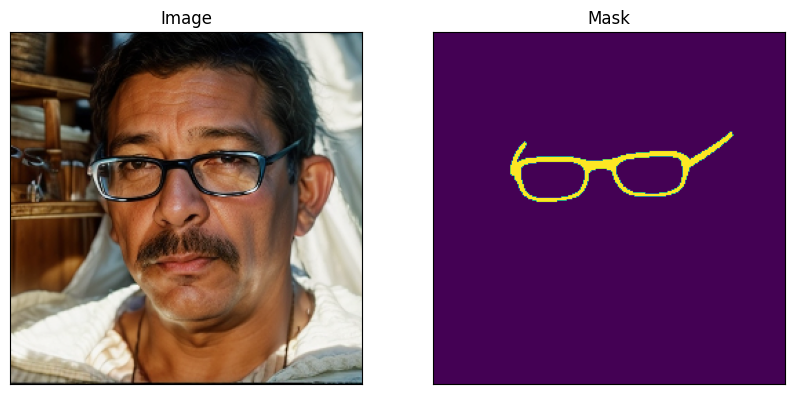

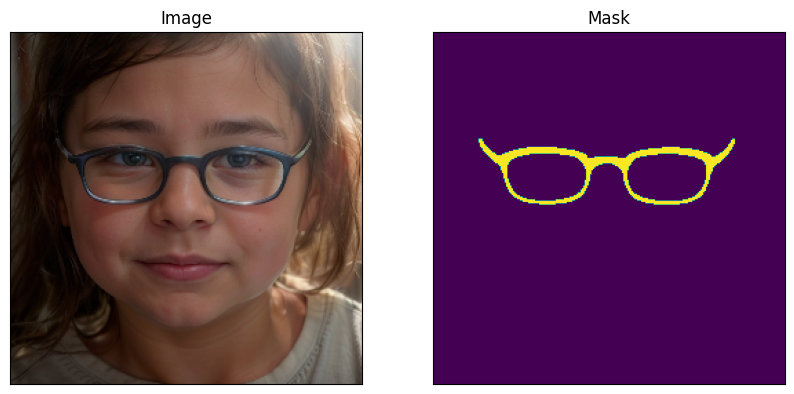

In [13]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

## Define the model


The UNet architecture is used for the segmentation task. The model is defined using the Keras functional API. The UNet model consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The encoder is a series of convolutions and max-pooling layers that reduce the spatial dimensions of the input. The decoder is a series of up-sampling and convolution layers that increase the spatial dimensions of the input. Skip connections are added between the encoder and decoder at the same spatial resolution to help the model make more accurate predictions.

Overall architecture:

![Unet](images/Unet.png)


### Encoder


The encoder is a stack of various conv blocks where each block will have two Conv2D layers each followed by a ReLU activation function. The number of filters will increase with the depth of the network. The encoder will downsample the input image into feature maps. The encoder will also have a max-pooling layer and a dropout layer to improve generalization.

![Encoder](images/Encoder.png)

In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  """
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  """
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  """
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    pool_size (int, int) -- size of the pooling layer
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    f - the output features of the convolution block
    p - the maxpooled features with dropout
  """

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  """
  Defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  """
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

### Bottleneck


A bottleneck follows the encoder block and is used to extract more features. It consists of two Conv2D layers followed by a dropout layer.

In [15]:
def bottleneck(inputs):
  """
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  """

  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

### Decoder

The decoder is a stack of various decoder blocks where each block will have two Conv2D layers each followed by a ReLU activation function. The number of filters will decrease with the depth of the network. The decoder will upsample the feature maps and concatenate them with the skip connections from the encoder to help the model make more accurate predictions. The decoder will also have a dropout layer to improve generalization.

![Decoder](images/Decoder.png)

In [16]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  """
  Defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    c (tensor) -- output features of the decoder block
  """
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  """
  Defines the decoder of the UNet chaining together 4 decoder blocks.

  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  """

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

### Putting it all together

Building the UNet by chaining the encoder, bottleneck, and decoder. The number of output channels is specified and equals the number of classes in the dataset. In this case, it is 2 because there are 2 possible labels for each pixel: eyeglasses or background.

In [17]:
OUTPUT_CHANNELS = 2

def unet():
  """
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  """

  inputs = tf.keras.layers.Input(shape=(size, size,3,))

  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

## Compile and Train the model

The model is compiled with the Adam optimizer and the loss function is sparse_categorical_crossentropy. The model is trained for 100 epochs with a batch size of 24.

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Custom callbacks are used to save the model according to the validation loss. The model is saved as an h5 file. After not improving for 6 epochs, the training is stopped early to prevent overfitting.

## Results

My model achieved a validation loss of 0.01180 after 66 epochs and stopped training.

In [19]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', patience=6):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.best = None
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if self.best is None or current < self.best:
                self.best = current
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nNo improvement in {self.monitor} for {self.patience} epochs, stopping training.")
                    self.model.stop_training = True


TRAIN_LENGTH = 1992
VAL_LENGTH = 489
EPOCHS = 100
STEPS_PER_EPOCH = 24
VALIDATION_STEPS = 5

callback = CustomEarlyStopping(monitor='val_loss', patience=6)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'my_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_dataset,
    callbacks=[callback, checkpoint]
)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 4.3216 - accuracy: 0.9388
Epoch 1: val_loss improved from inf to 0.17214, saving model to my_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 161s 3s/step - loss: 4.3216 - accuracy: 0.9388 - val_loss: 0.1721 - val_accuracy: 0.9676
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9656
Epoch 2: val_loss improved from 0.17214 to 0.13933, saving model to my_model.h5
24/24 [==============================] - 54s 2s/step - loss: 0.1623 - accuracy: 0.9656 - val_loss: 0.1393 - val_accuracy: 0.9667
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9660
Epoch 3: val_loss improved from 0.13933 to 0.11244, saving model to my_model.h5
24/24 [==============================] - 46s 2s/step - loss: 0.1326 - accuracy: 0.9660 - val_loss: 0.1124 - val_accuracy: 0.9664
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.1105 - accuracy: 0.9681
Epoch 4: val_loss improved from 0.11244 to 0.10303, saving model to my_model.h5
24/24 [==============================] - 46s 2s/step - loss: 0.1105 - accuracy: 0.9681 

### Load the model (optional)

Uncomment the cell below to load the model from the saved `.keras` file.

In [21]:
#model = tf.keras.models.load_model('my_model.h5')

## Make predictions

The functions below are used to make predictions on the test set and visualize the results. The model is used to predict the masks for the test images. The masks are then displayed alongside the original images.

In [22]:
def get_test_image_and_annotation_arrays():
  """
  Returns the input images and segmentation masks
  """
  images = []
  y_true_segments = []

  for image, annotation in test_dataset:
    y_true_segments = annotation.numpy()
    images = image.numpy()

  return images, y_true_segments

def create_mask(pred_mask):
  """
  Creates the segmentation mask by getting the channel with the highest probability.
  """
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  """
  Feeds an image to a model and returns the predicted mask.
  """

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

### Compute class wise metrics

Compute the IOU and Dice Score. The IOU is the intersection over the union of the predicted and true masks. The Dice Score is twice the area of overlap divided by the combined area. These metrics are used to evaluate the model's performance.

![IOU](images/IOU.png)
![Dice Score](images/DiceScore.png)

- Area of overlap - sum(True Positive)
- Combined area - sum(Total pixels in both True and Predicted masks)
- Area of union - sum(Total pixels in both True and Predicted masks) - Area of overlap

In [23]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(2):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

### Make predictions on the test set

In [24]:

y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

results = model.predict(test_dataset, steps=10)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

 1/10 [==>...........................] - ETA: 1:20

10/10 [==============================] - 9s 4ms/step


### Compute class wise metrics

In [ ]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

Show IOU for each class.

In [26]:
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-1 + 2)
  print("{}{}{} ".format(idx, spaces, iou))

0           0.9945657971524625 
1           0.8379794200944904 


Show the Dice Score for each class.

In [27]:
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-1 + 2)
  print("{}{}{} ".format(idx, spaces, dice_score))


0           0.9972754958298939 
1           0.9118485344788658 


### Display the predictions

As we can see, the model is able to accurately segment the eyeglasses in the images. The predictions are very close to the ground truth masks.

1/1 [==============================] - 2s 2s/step


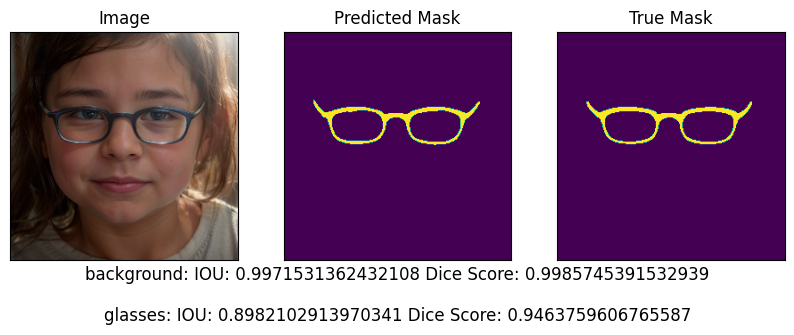

1/1 [==============================] - 0s 31ms/step


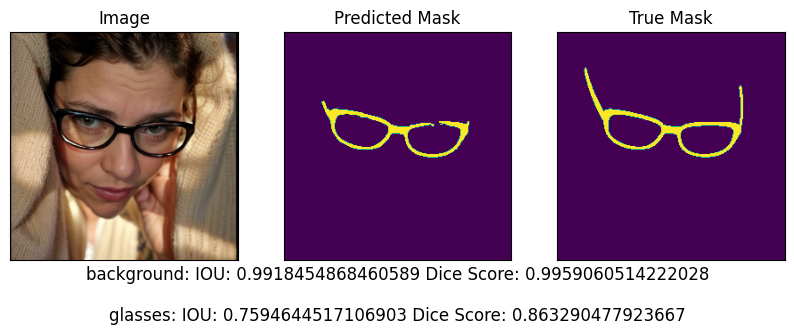

1/1 [==============================] - 0s 48ms/step


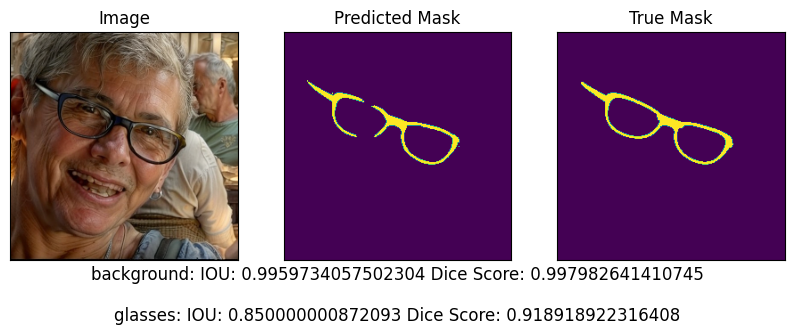

1/1 [==============================] - 0s 21ms/step


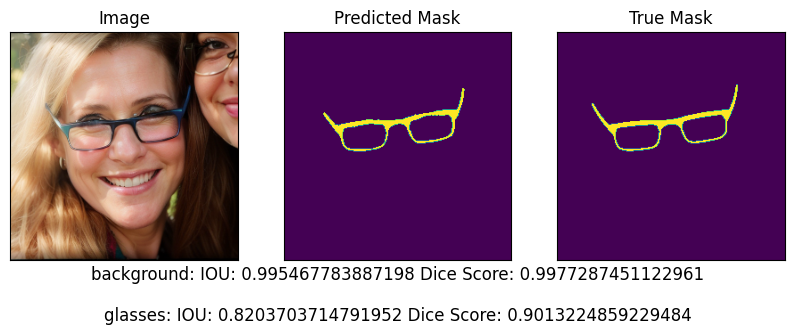

1/1 [==============================] - 0s 26ms/step


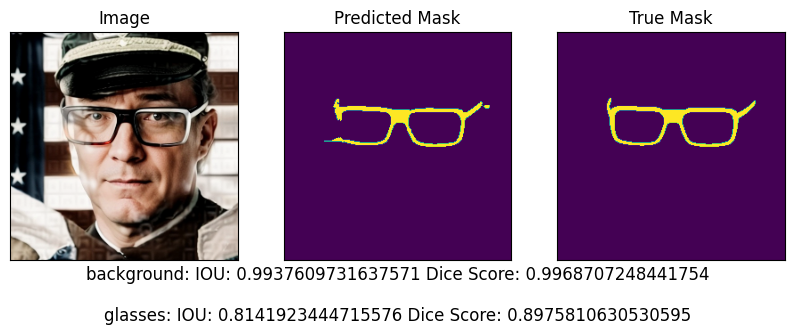

1/1 [==============================] - 0s 27ms/step


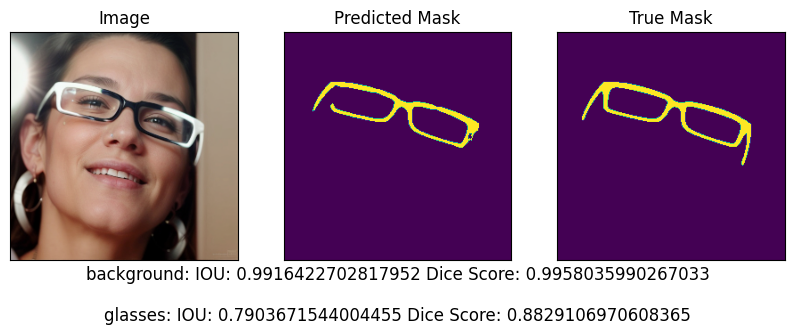

1/1 [==============================] - 0s 27ms/step


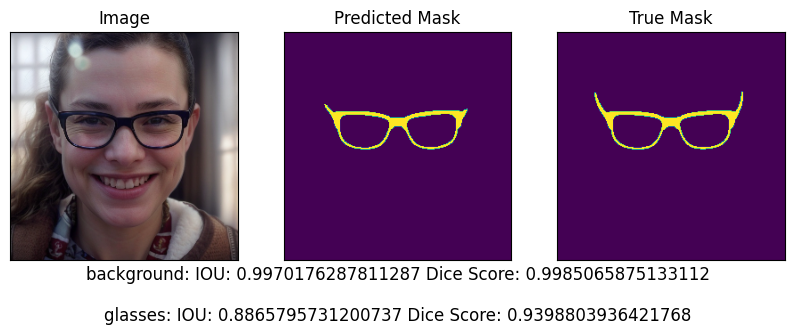

1/1 [==============================] - 0s 22ms/step


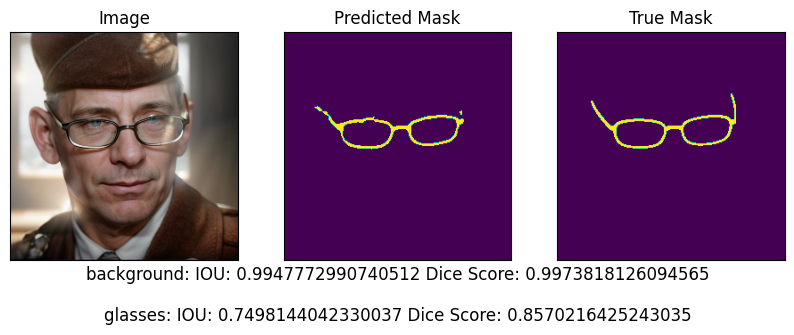

1/1 [==============================] - 0s 29ms/step


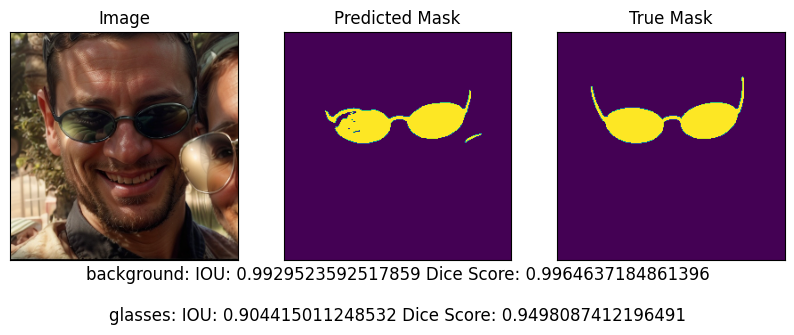

1/1 [==============================] - 0s 22ms/step


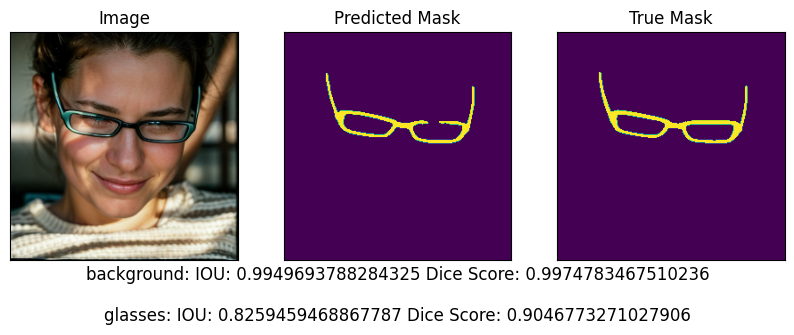

In [28]:
for integer_slider in range(10):
    y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

    iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

    display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)
